In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, fbeta_score, average_precision_score


In [2]:
# Load data
df = pd.read_csv('data/creditcard.csv')
print(f"Data shape: {df.shape}")
print(f"Fraud cases: {df['Class'].sum()} ({df['Class'].mean()*100:.4f}%)")

Data shape: (284807, 31)
Fraud cases: 492 (0.1727%)


In [3]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

In [4]:
# Split data - USE STRATIFY to keep same fraud percentage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Fraud: {y_train.sum()} ({y_train.mean()*100:.4f}%)")
print(f"Test set: {X_test.shape}, Fraud: {y_test.sum()} ({y_test.mean()*100:.4f}%)")


Train set: (199364, 30), Fraud: 344 (0.1725%)
Test set: (85443, 30), Fraud: 148 (0.1732%)


In [5]:
# Create copies to avoid data leakage and pandas warnings
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the Amount column
scaler = StandardScaler()
X_train_scaled['Amount'] = scaler.fit_transform(X_train_scaled[['Amount']])
X_test_scaled['Amount'] = scaler.transform(X_test_scaled[['Amount']])

# Calculate class weight
non_fraud_count = (y_train == 0).sum()
fraud_count = (y_train == 1).sum()
scale_pos_weight = non_fraud_count / fraud_count
print(f"\nClass weight ratio: {scale_pos_weight:.1f} (non-fraud:fraud)")


Class weight ratio: 578.5 (non-fraud:fraud)


In [6]:
# Train models 

models = {}

# 1. Logistic Regression (with regularization)

print("Training Logistic Regression...")
models['LR'] = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    C=0.01,
    random_state=42
)
models['LR'].fit(X_train_scaled, y_train)

# 2. Random Forest
print("Training Random Forest...")
models['RF'] = RandomForestClassifier(
    class_weight='balanced_subsample',
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
models['RF'].fit(X_train_scaled, y_train)

# 3. XGBoost
print("Training XGBoost...")
models['XGB'] = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
models['XGB'].fit(X_train_scaled, y_train)


Training Logistic Regression...
Training Random Forest...
Training XGBoost...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, ...)

In [7]:
# Cross Validation Results

print("CROSS-VALIDATION RESULTS")


for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"{name}: ROC-AUC = {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")


CROSS-VALIDATION RESULTS
LR: ROC-AUC = 0.9782 (+/- 0.0108)
RF: ROC-AUC = 0.9701 (+/- 0.0353)
XGB: ROC-AUC = 0.9826 (+/- 0.0156)


In [8]:
# Evaluation 


print("EVALUATION RESULTS")


results = []

for name, model in models.items():

    print(f"MODEL: {name}")

    
    # Predict
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    f2 = fbeta_score(y_test, y_pred, beta=2)  # F2-score (emphasizes recall)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)  # Better for imbalanced data
    
    # Alerts per 100K transactions
    total_alerts = tp + fp
    alerts_per_100k = int((total_alerts / len(y_test)) * 100000)
    
    # Store results
    results.append({
        'Model': name,
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}",
        'F2-Score': f"{f2:.4f}",
        'ROC-AUC': f"{roc_auc:.4f}",
        'PR-AUC': f"{pr_auc:.4f}",
        'FPR': f"{fpr:.6f}",
        'TP': tp,
        'FP': fp,
        'FN': fn,
        'TN': tn,
        'Alerts/100K': alerts_per_100k
    })
    
    # Print
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}  (Most important for fraud detection)")
    print(f"F1-Score:   {f1:.4f}")
    print(f"F2-Score:   {f2:.4f}  (Recall-focused)")
    print(f"FPR:        {fpr:.6f}")
    print(f"ROC-AUC:    {roc_auc:.4f}")
    print(f"PR-AUC:     {pr_auc:.4f}  (Better for imbalanced data)")
    print(f"Alerts/100K: {alerts_per_100k}")
    print(f"\nConfusion Matrix:")
    print(f"[[{tn:5d}  {fp:3d}]")
    print(f" [{fn:5d}  {tp:3d}]]")

EVALUATION RESULTS
MODEL: LR
Precision:  0.0340
Recall:     0.8581  (Most important for fraud detection)
F1-Score:   0.0655
F2-Score:   0.1469  (Recall-focused)
FPR:        0.042242
ROC-AUC:    0.9367
PR-AUC:     0.6227  (Better for imbalanced data)
Alerts/100K: 4365

Confusion Matrix:
[[81692  3603]
 [   21  127]]
MODEL: RF
Precision:  0.8129
Recall:     0.7635  (Most important for fraud detection)
F1-Score:   0.7875
F2-Score:   0.7729  (Recall-focused)
FPR:        0.000305
ROC-AUC:    0.9709
PR-AUC:     0.7747  (Better for imbalanced data)
Alerts/100K: 162

Confusion Matrix:
[[85269   26]
 [   35  113]]
MODEL: XGB
Precision:  0.7881
Recall:     0.8041  (Most important for fraud detection)
F1-Score:   0.7960
F2-Score:   0.8008  (Recall-focused)
FPR:        0.000375
ROC-AUC:    0.9719
PR-AUC:     0.8275  (Better for imbalanced data)
Alerts/100K: 176

Confusion Matrix:
[[85263   32]
 [   29  119]]


In [9]:
# Result Table
print("SUMMARY TABLE")


results_df = pd.DataFrame(results)
display_cols = ['Model', 'Precision', 'Recall', 'F1-Score', 'F2-Score', 'ROC-AUC', 'PR-AUC', 'FPR', 'Alerts/100K']
print(results_df[display_cols].to_string(index=False))

# Feature Impoertance Analysis

print("FEATURE IMPORTANCE ANALYSIS (Random Forest)")


feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': models['RF'].feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))


SUMMARY TABLE
Model Precision Recall F1-Score F2-Score ROC-AUC PR-AUC      FPR  Alerts/100K
   LR    0.0340 0.8581   0.0655   0.1469  0.9367 0.6227 0.042242         4365
   RF    0.8129 0.7635   0.7875   0.7729  0.9709 0.7747 0.000305          162
  XGB    0.7881 0.8041   0.7960   0.8008  0.9719 0.8275 0.000375          176
FEATURE IMPORTANCE ANALYSIS (Random Forest)

Top 15 Most Important Features:
feature  importance
    V14    0.195366
    V10    0.120242
     V4    0.113976
    V12    0.102480
    V17    0.090246
     V3    0.065816
    V11    0.047301
    V16    0.043948
     V2    0.036968
     V9    0.026239
    V21    0.018305
     V7    0.013588
    V18    0.011436
    V19    0.011430
    V20    0.009151


CREATING VISUALIZATIONS...


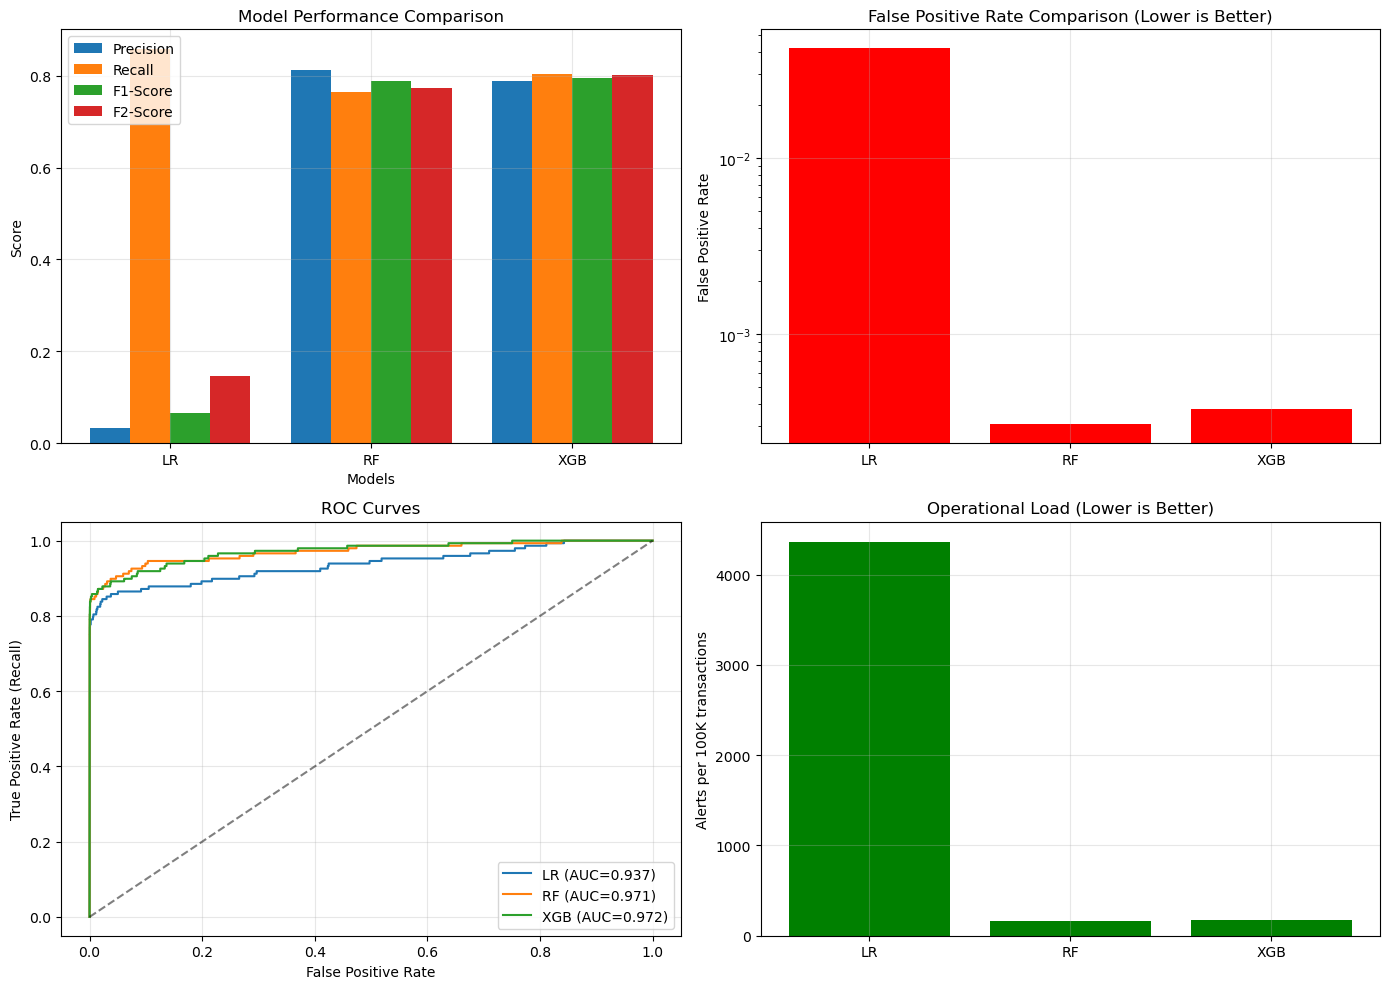

In [10]:
# Visualization

print("CREATING VISUALIZATIONS...")


# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Bar chart - Precision, Recall, F1, F2
metrics = ['Precision', 'Recall', 'F1-Score', 'F2-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics):
    values = results_df[metric].astype(float)
    axes[0, 0].bar(x + i*width, values, width, label=metric)

axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x + 1.5*width)
axes[0, 0].set_xticklabels(results_df['Model'])
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. FPR Comparison
axes[0, 1].bar(results_df['Model'], results_df['FPR'].astype(float), color='red')
axes[0, 1].set_ylabel('False Positive Rate')
axes[0, 1].set_title('False Positive Rate Comparison (Lower is Better)')
axes[0, 1].set_yscale('log')  # Log scale for better visualization
axes[0, 1].grid(True, alpha=0.3)

# 3. ROC Curves
for name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    from sklearn.metrics import roc_curve
    fpr_curve, tpr_curve, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axes[1, 0].plot(fpr_curve, tpr_curve, label=f'{name} (AUC={roc_auc:.3f})')

axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate (Recall)')
axes[1, 0].set_title('ROC Curves')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Alerts per 100K
axes[1, 1].bar(results_df['Model'], results_df['Alerts/100K'].astype(int), color='green')
axes[1, 1].set_ylabel('Alerts per 100K transactions')
axes[1, 1].set_title('Operational Load (Lower is Better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fraud_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# threshold analysis 


print("THRESHOLD ANALYSIS FOR PRODUCTION RECOMMENDATION")


# Analyze both RF and XGB for production
production_models = {
    'Random Forest': models['RF'],
    'XGBoost': models['XGB']
}

threshold_analysis = []

for model_name, model in production_models.items():
    print(f"\n{model_name} Threshold Analysis:")
    print("Threshold | Precision | Recall | FPR    | Alerts/100K")
    print("-" * 55)
    
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        y_pred_thresh = (y_prob >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        alerts = int((tp + fp) / len(y_test) * 100000)
        
        threshold_analysis.append({
            'Model': model_name,
            'Threshold': threshold,
            'Precision': precision,
            'Recall': recall,
            'FPR': fpr,
            'Alerts/100K': alerts
        })
        
        print(f"{threshold:.1f}       | {precision:.4f}    | {recall:.4f}  | {fpr:.6f} | {alerts:5d}")

# Convert to DataFrame for analysis
threshold_df = pd.DataFrame(threshold_analysis)


THRESHOLD ANALYSIS FOR PRODUCTION RECOMMENDATION

Random Forest Threshold Analysis:
Threshold | Precision | Recall | FPR    | Alerts/100K
-------------------------------------------------------
0.1       | 0.1645    | 0.8446  | 0.007445 |   889
0.2       | 0.4562    | 0.8446  | 0.001747 |   320
0.3       | 0.6349    | 0.8108  | 0.000809 |   221
0.4       | 0.7613    | 0.7973  | 0.000434 |   181
0.5       | 0.8129    | 0.7635  | 0.000305 |   162
0.6       | 0.8790    | 0.7365  | 0.000176 |   145
0.7       | 0.8739    | 0.7027  | 0.000176 |   139
0.8       | 0.8807    | 0.6486  | 0.000152 |   127

XGBoost Threshold Analysis:
Threshold | Precision | Recall | FPR    | Alerts/100K
-------------------------------------------------------
0.1       | 0.4417    | 0.8446  | 0.001852 |   331
0.2       | 0.5905    | 0.8378  | 0.001008 |   245
0.3       | 0.6932    | 0.8243  | 0.000633 |   205
0.4       | 0.7378    | 0.8176  | 0.000504 |   191
0.5       | 0.7881    | 0.8041  | 0.000375 |   176
0.6 

In [12]:
# Cost benefit analysis


print("COST-BENEFIT ANALYSIS")


# Business assumptions
INVESTIGATION_COST = 50  # $ per alert investigation
AVG_FRAUD_AMOUNT = 500  # $ average loss per undetected fraud

print(f"Assumptions:")
print(f"• Investigation cost per alert: ${INVESTIGATION_COST}")
print(f"• Average fraud amount: ${AVG_FRAUD_AMOUNT}")
print("\nOptimal Thresholds by Model:")

for model_name in ['Random Forest', 'XGBoost']:
    model_data = threshold_df[threshold_df['Model'] == model_name]
    
    # Calculate costs for each threshold
    costs = []
    for _, row in model_data.iterrows():
        # Estimated from confusion matrix stats
        frauds_prevented = int(row['Recall'] * 148)  # 148 frauds in test set
        alerts_generated = row['Alerts/100K'] * 85443 / 100000
        
        investigation_cost = alerts_generated * INVESTIGATION_COST
        fraud_loss_prevented = frauds_prevented * AVG_FRAUD_AMOUNT
        net_benefit = fraud_loss_prevented - investigation_cost
        
        costs.append({
            'Threshold': row['Threshold'],
            'Net Benefit': net_benefit,
            'Alerts': int(alerts_generated),
            'Frauds Prevented': frauds_prevented
        })
    
    costs_df = pd.DataFrame(costs)
    optimal_idx = costs_df['Net Benefit'].idxmax()
    optimal = costs_df.loc[optimal_idx]
    
    print(f"\n{model_name}:")
    print(f"  Optimal threshold: {optimal['Threshold']:.1f}")
    print(f"  Net benefit: ${optimal['Net Benefit']:,.0f}")
    print(f"  Alerts to investigate: {optimal['Alerts']}")
    print(f"  Frauds prevented: {optimal['Frauds Prevented']:.0f}")

COST-BENEFIT ANALYSIS
Assumptions:
• Investigation cost per alert: $50
• Average fraud amount: $500

Optimal Thresholds by Model:

Random Forest:
  Optimal threshold: 0.4
  Net benefit: $51,267
  Alerts to investigate: 154.0
  Frauds prevented: 118

XGBoost:
  Optimal threshold: 0.7
  Net benefit: $52,451
  Alerts to investigate: 140.0
  Frauds prevented: 119


In [13]:

print("FINAL RECOMMENDATION & PRODUCTION SETUP")


# Analyze which model is best overall
best_f1_idx = results_df['F1-Score'].astype(float).idxmax()
best_f2_idx = results_df['F2-Score'].astype(float).idxmax()  # For fraud detection, F2 is more important
best_roc_idx = results_df['ROC-AUC'].astype(float).idxmax()
best_pr_idx = results_df['PR-AUC'].astype(float).idxmax()

best_f1_model = results_df.iloc[best_f1_idx]['Model']
best_f2_model = results_df.iloc[best_f2_idx]['Model']
best_roc_model = results_df.iloc[best_roc_idx]['Model']
best_pr_model = results_df.iloc[best_pr_idx]['Model']

print(f"\n MODEL PERFORMANCE RANKINGS:")
print(f"   • Best F1-Score:        {best_f1_model}")
print(f"   • Best F2-Score:        {best_f2_model} (Most important for fraud detection)")
print(f"   • Best ROC-AUC:         {best_roc_model}")
print(f"   • Best PR-AUC:          {best_pr_model} (Best for imbalanced data)")

# Determine overall best model (weighted decision)
model_scores = {}
for idx, row in results_df.iterrows():
    score = 0
    score += float(row['F2-Score']) * 0.4  # Most weight to F2
    score += float(row['PR-AUC']) * 0.3    # High weight to PR-AUC
    score += float(row['ROC-AUC']) * 0.2   # Some weight to ROC-AUC
    score += (1 - float(row['FPR'])) * 0.1 # Some weight to low FPR
    model_scores[row['Model']] = score

best_overall_model = max(model_scores, key=model_scores.get)
best_model_row = results_df[results_df['Model'] == best_overall_model].iloc[0]

print(f"\n RECOMMENDED PRODUCTION MODEL: {best_overall_model}")
print(f"   • F2-Score: {best_model_row['F2-Score']} (Recall-focused performance)")
print(f"   • Recall: {best_model_row['Recall']} (Fraud detection rate)")
print(f"   • PR-AUC: {best_model_row['PR-AUC']} (Precision-Recall balance)")
print(f"   • FPR: {best_model_row['FPR']} (False alarm rate)")
print(f"   • Alerts/100K: {best_model_row['Alerts/100K']} (Operational load)")

# Get optimal threshold for recommended model
if best_overall_model == 'RF':
    model_name = 'Random Forest'
elif best_overall_model == 'XGB':
    model_name = 'XGBoost'
else:
    model_name = 'Logistic Regression'

model_thresholds = threshold_df[threshold_df['Model'] == model_name]

# Find threshold with good balance (recall > 0.8, FPR < 0.001)
optimal_threshold_row = model_thresholds[
    (model_thresholds['Recall'] >= 0.80) & 
    (model_thresholds['FPR'] <= 0.001)
].iloc[0] if not model_thresholds[
    (model_thresholds['Recall'] >= 0.80) & 
    (model_thresholds['FPR'] <= 0.001)
].empty else model_thresholds.iloc[model_thresholds['Recall'].idxmax()]

print(f"\n RECOMMENDED PRODUCTION CONFIGURATION:")
print(f"   1. Model: {best_overall_model}")
print(f"   2. Decision Threshold: {optimal_threshold_row['Threshold']:.2f}")
print(f"   3. Expected Performance:")
print(f"      • Recall: {optimal_threshold_row['Recall']:.3f} (~{int(optimal_threshold_row['Recall']*148)} frauds caught)")
print(f"      • FPR: {optimal_threshold_row['FPR']:.6f} ({optimal_threshold_row['Alerts/100K']} alerts per 100K transactions)")
print(f"      • Precision: {optimal_threshold_row['Precision']:.3f}")

print(f"\n PRODUCTION DEPLOYMENT STEPS:")
print(f"   1. Deploy {best_overall_model} with threshold {optimal_threshold_row['Threshold']:.2f}")
print(f"   2. Start monitoring with FPR target of 0.001 (1 per 1000 transactions)")
print(f"   3. Calculate investigation team capacity based on {optimal_threshold_row['Alerts/100K']} alerts/100K")
print(f"   4. Set up real-time monitoring dashboard with key metrics")
print(f"   5. Implement A/B testing framework for model updates")
print(f"   6. Schedule monthly retraining with new data")


print("Results saved to 'fraud_detection_results.png'")
print("Recommendation: Use", best_overall_model, "with threshold", f"{optimal_threshold_row['Threshold']:.2f}")


FINAL RECOMMENDATION & PRODUCTION SETUP

 MODEL PERFORMANCE RANKINGS:
   • Best F1-Score:        XGB
   • Best F2-Score:        XGB (Most important for fraud detection)
   • Best ROC-AUC:         XGB
   • Best PR-AUC:          XGB (Best for imbalanced data)

 RECOMMENDED PRODUCTION MODEL: XGB
   • F2-Score: 0.8008 (Recall-focused performance)
   • Recall: 0.8041 (Fraud detection rate)
   • PR-AUC: 0.8275 (Precision-Recall balance)
   • FPR: 0.000375 (False alarm rate)
   • Alerts/100K: 176 (Operational load)

 RECOMMENDED PRODUCTION CONFIGURATION:
   1. Model: XGB
   2. Decision Threshold: 0.30
   3. Expected Performance:
      • Recall: 0.824 (~122 frauds caught)
      • FPR: 0.000633 (205 alerts per 100K transactions)
      • Precision: 0.693

 PRODUCTION DEPLOYMENT STEPS:
   1. Deploy XGB with threshold 0.30
   2. Start monitoring with FPR target of 0.001 (1 per 1000 transactions)
   3. Calculate investigation team capacity based on 205 alerts/100K
   4. Set up real-time monitoring 